In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics, preprocessing

import tensorflow as tf
from tensorflow.keras import models, layers, utils  

2023-09-12 15:46:10.867904: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# pip install recmetrics

In [3]:
# import recmetrics

# 1. Loading Data

I will be using data from the [MovieLens dataset](https://grouplens.org/datasets/movielens/latest/). The MovieLens dataset was produced by [GroupLens Research](https://en.wikipedia.org/wiki/GroupLens_Research), a lab out of the University of Minnesota, and is a popular dataset for building movie recommender systems. 

In [4]:
## movies data
movies = pd.read_csv("data/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
## user ratings data
ratings = pd.read_csv("data/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# 2. Data Preprocessing and EDA

Initially, I noticed that the movieId's start counting from 1 rather than 0. I prefer working with UID's that begin at 0 because it is more compactible with pandas indexing. I am going to reset the movie ID's and assign the new ID's to the <strong>*movie*</strong> column. Next, I will extract the movie's name and year from the <strong>*title*</strong> column and store in their own respective columns. Lastly, let's flag if a movie is made before the year 2000 and assign it the the <strong>*old*</strong> column. We can use this as a possible feature later in our content-based model. This is a good start with the movies dataframe. Let's move onto the ratings dataframe for initial cleaning and preprocessing. 

In [6]:
## Movies
## assign new movie id to "movie"
movies["movie"] = range(0,len(movies))

## extract the movie's name from the "title" column
movies["name"] = movies["title"].str.split(r"(").str[0]

## extract the movie's year from the "title" column
movies["year"] = movies["title"].apply(lambda x: int(x.split(r"(")[-1][0:4]) if r"(" in x else np.nan)

## flag if year is < 2000
movies["old"] = movies["year"].apply(lambda x: 1 if x < 2000 else 0)
movies.head()

,movieId,title,genres,movie,name,year,old
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,Toy Story,1995.0,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,Jumanji,1995.0,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2,Grumpier Old Men,1995.0,1
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3,Waiting to Exhale,1995.0,1
4,5,Father of the Bride Part II (1995),Comedy,4,Father of the Bride Part II,1995.0,1


Again, I am going to reset the user IDs to start with 0 as the first ID and assign to the <strong>*user*</strong> column. Now, let's work with the <strong>*timestamp*</strong> column. The timestamps are currently being stored as integers, converting them to Timestamp objects will allow for easier manipulation and feature engineering. We can now use Timestamp functions to flag whether the movie was watched during the daytime and/or on the weekend. Last thing we need to do is map <strong>*movieID*</strong> to <strong>*movie*</strong> since we are going to be using the reset indices moving forward. 

In [7]:
## ratings
## scale new user id starting at 0 and assign to "user"
ratings["user"] = ratings["userId"].apply(lambda x: x-1)

## converting timestamp int into Timestamp
ratings["timestamp"] = ratings["timestamp"].apply(lambda x: datetime.fromtimestamp(x))

## flagging if timestamp is during the daytime
ratings["daytime"] = ratings["timestamp"].apply(lambda x: 1 if 6<int(x.strftime("%H"))<20 else 0)

## flagging if timestamp is on the weekend
ratings["weekend"] = ratings["timestamp"].apply(lambda x: 1 if x.weekday() in [5,6] else 0)

## adding new movie id column "movie" to ratings df
ratings = ratings.merge(movies[["movieId","movie"]], how="left")

## rename "rating" to "y" (this is our target variable)
ratings = ratings.rename(columns={"rating":"y"})
ratings.head()

,userId,movieId,y,timestamp,user,daytime,weekend,movie
0,1,1,4.0,2000-07-30 11:45:03,0,1,1,0
1,1,3,4.0,2000-07-30 11:20:47,0,1,1,2
2,1,6,4.0,2000-07-30 11:37:04,0,1,1,5
3,1,47,5.0,2000-07-30 12:03:35,0,1,1,43
4,1,50,5.0,2000-07-30 11:48:51,0,1,1,46


The final step to preprocessing is to select only the clean columns for each dataset. 

In [8]:
## clean movies
movies = movies[["movie","name","old","genres"]].set_index("movie")
movies.head()

,name,old,genres
movie,,,
0,Toy Story,1,Adventure|Animation|Children|Comedy|Fantasy
1,Jumanji,1,Adventure|Children|Fantasy
2,Grumpier Old Men,1,Comedy|Romance
3,Waiting to Exhale,1,Comedy|Drama|Romance
4,Father of the Bride Part II,1,Comedy


In [9]:
## clean users
ratings = ratings[["user","movie","daytime","weekend","y"]]
ratings.head()

,user,movie,daytime,weekend,y
0,0,0,1,1,4.0
1,0,2,1,1,4.0
2,0,5,1,1,4.0
3,0,43,1,1,5.0
4,0,46,1,1,5.0


About 68% of the movies in our dataset were watched during the daytime and about 70% of the movies were watched during on a weekday (<strong>*daytime*</strong> and <strong>*weekend*</strong> are independent variables). I won't be using either feature in the models, so let's save the to a <strong>*reference*</strong> dataframe. 

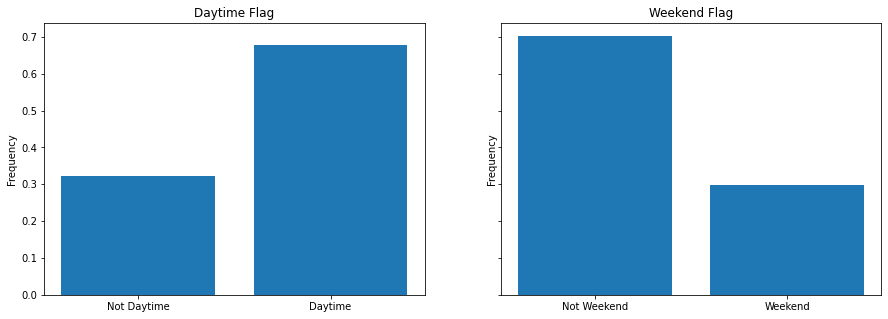

In [10]:
## daytime and weekend frequency
daytime = ratings.groupby("daytime").count().reset_index()[["daytime", "y"]].rename(columns={"y":"count"})
daytime["frequency"] = daytime["count"]/sum(daytime["count"])
daytime["daytime"] = daytime["daytime"].apply(lambda x: "Daytime" if x == 1 else "Not Daytime")
daytime

weekend = ratings.groupby("weekend").count().reset_index()[["weekend", "y"]].rename(columns={"y":"count"})
weekend["frequency"] = weekend["count"]/sum(weekend["count"])
weekend["weekend"] = weekend["weekend"].apply(lambda x: "Weekend" if x == 1 else "Not Weekend")
weekend

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,5))
ax[0].set(title="Daytime Flag")
ax[0].bar(daytime["daytime"], daytime["frequency"])
ax[0].set_ylabel('Frequency', color='black')
ax[1].set(title="Weekend Flag")
ax[1].bar(weekend["weekend"], weekend["frequency"])
ax[1].set_ylabel('Frequency', color='black');

In [11]:
## reference 
reference = ratings[["user","movie","daytime","weekend"]]
reference.head()

,user,movie,daytime,weekend
0,0,0,1,1
1,0,2,1,1
2,0,5,1,1
3,0,43,1,1
4,0,46,1,1


Now it's time to better understand our users. Let's see how many movies each of our users have watched and what each of their average ratings are.

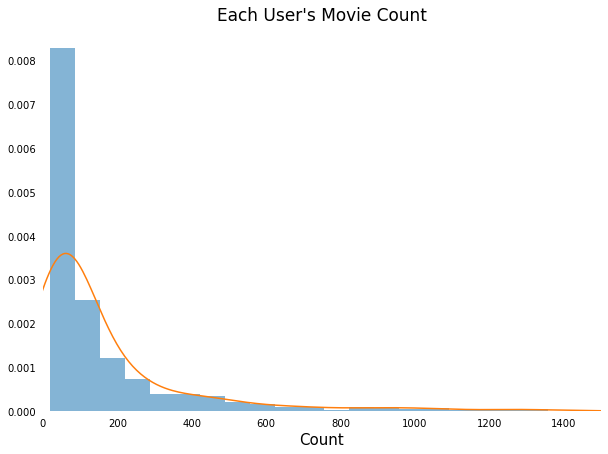

In [12]:
## How many movies has each user's watched?
user_counts = ratings.groupby("user").count()["y"]
user_counts

## plot the distribution of each user's movie count
fig, ax = plt.subplots(figsize = (10,7))

user_counts.plot(kind = "hist", density = True, alpha = 0.55, bins = 40) 
user_counts.plot(kind = "kde")
plt.style.use("bmh")

ax.set_xlabel("Count", size=15)
ax.set_xlim(0, 1500)
ax.set_ylabel("")

ax.set_title("Each User's Movie Count", size = 17, pad = 10)
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)
plt.show()

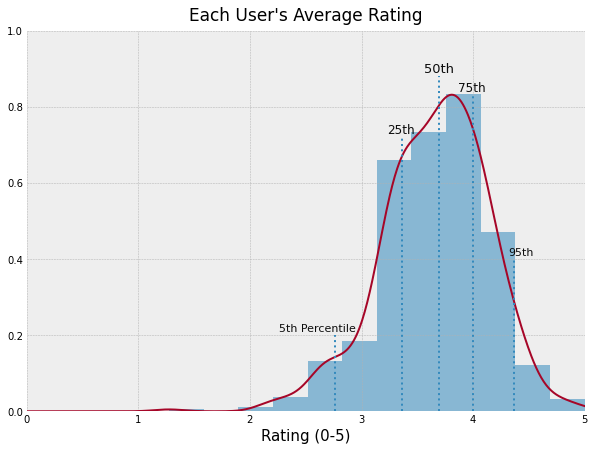

In [13]:
## What is each user's average rating?
avg_user_rating = ratings.groupby("user").mean()["y"]
avg_user_rating

## plot the distribution of each user's average rating
fig, ax = plt.subplots(figsize = (10,7))

avg_user_rating.plot(kind = "hist", density = True, alpha = 0.55, bins = 12) 
avg_user_rating.plot(kind = "kde")
plt.style.use("bmh")

# add percentiles
quant_5, quant_25, quant_50, quant_75, quant_95 = avg_user_rating.quantile(0.05), avg_user_rating.quantile(0.25), avg_user_rating.quantile(0.5), avg_user_rating.quantile(0.75), avg_user_rating.quantile(0.95)
quants = [[quant_5, 1, 0.20], [quant_25, 1, 0.72], [quant_50, 1, 0.88],  [quant_75, 1, 0.83], [quant_95, 1, 0.40]]
for i in quants:
    ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")
    
ax.text(quant_5-.5, 0.21, "5th Percentile", size = 11, alpha = 0.95)
ax.text(quant_25-.13, 0.73, "25th", size = 12, alpha = 0.95)
ax.text(quant_50-.13, 0.89, "50th", size = 13, alpha = 0.95)
ax.text(quant_75-.13, 0.84, "75th", size = 12, alpha = 0.95)
ax.text(quant_95-.05, 0.41, "95th", size = 11, alpha =.95)

ax.set_xlabel("Rating (0-5)", size=15)
ax.set_xlim(0, 5)
ax.set_ylim(0,1)
ax.set_ylabel("")

ax.set_title("Each User's Average Rating", size = 17, pad = 10)
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)
plt.show()

Next, we will explore our <strong>*movie*</strong>  dataframe. Again, let's look at the average rating for each movie and the count of ratings each movie received. 

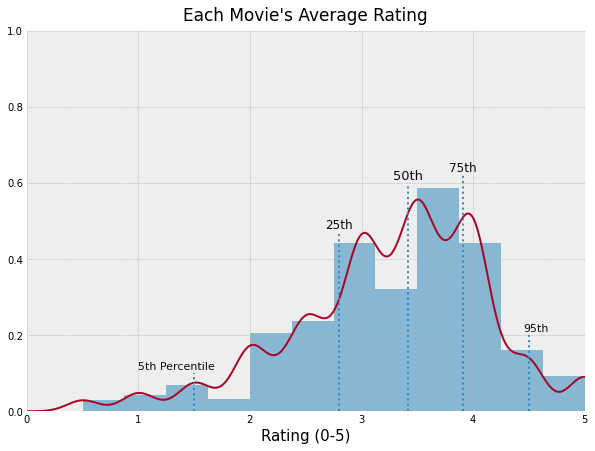

In [14]:
## What is each movie's average rating?
avg_movie_rating = ratings.groupby("movie").mean()["y"]
avg_movie_rating

## plot the distribution of each movie's average rating
fig, ax = plt.subplots(figsize = (10,7))

avg_movie_rating.plot(kind = "hist", density = True, alpha = 0.55, bins = 12) 
avg_movie_rating.plot(kind = "kde")
plt.style.use("bmh")

# add percentiles
quant_5, quant_25, quant_50, quant_75, quant_95 = avg_movie_rating.quantile(0.05), avg_movie_rating.quantile(0.25), avg_movie_rating.quantile(0.5), avg_movie_rating.quantile(0.75), avg_movie_rating.quantile(0.95)
quants = [[quant_5, 1, 0.10], [quant_25, 1, 0.47], [quant_50, 1, 0.60],  [quant_75, 1, 0.62], [quant_95, 1, 0.20]]
for i in quants:
    ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")
    
ax.text(quant_5-.5, 0.11, "5th Percentile", size = 11, alpha = 0.95)
ax.text(quant_25-.13, 0.48, "25th", size = 12, alpha = 0.95)
ax.text(quant_50-.13, 0.61, "50th", size = 13, alpha = 0.95)
ax.text(quant_75-.13, 0.63, "75th", size = 12, alpha = 0.95)
ax.text(quant_95-.05, 0.21, "95th", size = 11, alpha =.95)

ax.set_xlabel("Rating (0-5)", size=15)
ax.set_xlim(0, 5)
ax.set_ylim(0,1)
ax.set_ylabel("")

ax.set_title("Each Movie's Average Rating", size = 17, pad = 10)
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)
plt.show()

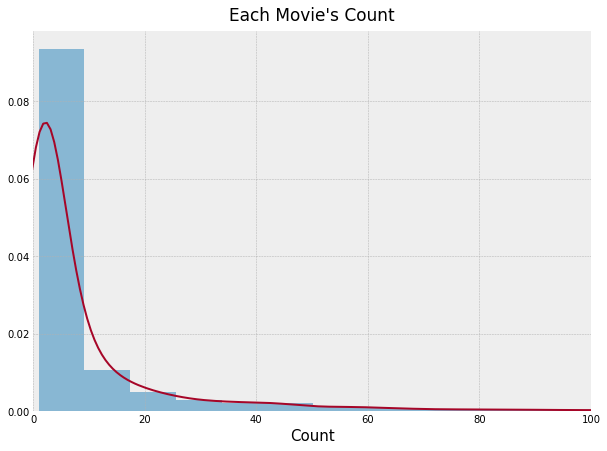

In [15]:
## How many times has each movie been watched?
movie_counts = ratings.groupby("movie").count()["y"]
movie_counts

## plot the distribution of each user's movie count
fig, ax = plt.subplots(figsize = (10,7))

movie_counts.plot(kind = "hist", density = True, alpha = 0.55, bins = 40) 
movie_counts.plot(kind = "kde")
plt.style.use("bmh")

ax.set_xlabel("Count", size=15)
ax.set_xlim(0, 100)
ax.set_ylabel("")

ax.set_title("Each Movie's Count", size = 17, pad = 10)
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)
plt.show()

Nothing strange stands out to me about the movie's average rating distribution and we see that most movies are watched by only a fraction of users. This is similar to what we saw with the users. Let's visualise how sparse the Users X Movies data is with a heatmap to get a better understanding. 

And, while we are working with it, let's scale user ratings between 0.5 and 1. In general, you should scale ratings between 0 and 1, but since 0's will later be used to represent user's unwatched movies, we will scale watched movies starting from 0.5. 

In [16]:
## Create Users x Movies dataframe
users_tmp = ratings.copy()
users_movies = users_tmp.pivot(index="user", columns="movie", values="y")

missing_cols = list(set(movies.index) - set(users_movies.columns))
for col in missing_cols:
    users_movies[col] = np.nan
users_movies = users_movies[sorted(users_movies.columns)]

## scale all ratings between 0.5 and 1
users_movies = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(users_movies.values), columns=users_movies.columns, index=users_movies.index)
users_movies

users_movies

/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


movie,0,1,2,3,4,5,6,7,8,9,...,9732,9733,9734,9735,9736,9737,9738,9739,9740,9741
user,,,,,,,,,,,,,,,,,,,,,
0,0.888889,NaN,0.888889,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.888889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.722222,NaN,NaN,NaN,NaN,NaN,0.6875,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,0.888889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,0.722222,0.666667,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,0.888889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


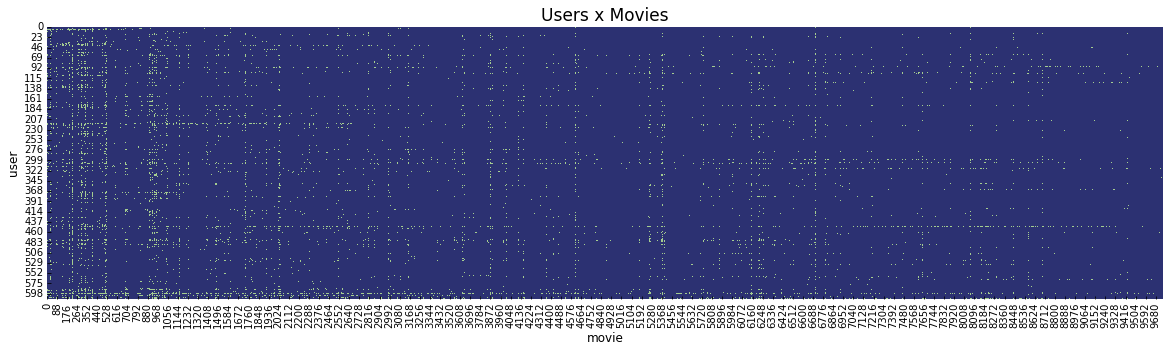

In [17]:
## How sparse is our Users X Movies data?
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(users_movies.isnull(), vmin=0, vmax=1, cbar=False, cmap='crest', ax=ax).set_title("Users x Movies", size=17)
plt.show()

# 3. Train and Run Model

In [18]:
def unseenMovies(users_movies_df):
    """
    Returns a dictionary of each user's unseen movies.
    args:
        users_movies_df [(int) x, (int) z]: users x movies rating (null indicates unseen)
    returns:
        unseen_dict {user1: [movie1, movie2, ...], ...}: each user's unseen movies
    """
    unseen_dict = {}
    for user in range(len(users_movies_df)): 
        obs = users_movies_df.iloc[user, :]
        unseen_movies = obs[obs.isna()].index
        unseen_dict[user] = unseen_movies
    return unseen_dict

In [19]:
## converting ratings to implicit data
ratings = users_movies.stack(dropna=True).reset_index().rename({0: "y"}, axis=1)
ratings["y"] = 1


## adding negative datapoints
user_unseen_movies = unseenMovies(users_movies)

for u in np.unique(ratings["user"]):
    num_negatives = sum(ratings["user"] == 1) * 4
    random_negatives = np.random.choice(user_unseen_movies[u], num_negatives, replace=False)
    df = pd.DataFrame({"user":u, "movie":random_negatives, "y":0})
    ratings = pd.concat([ratings, df])
    
## shuffle data and downsize
ratings = ratings.sample(frac=0.5, random_state=42, replace=False).reset_index(drop=True)
ratings


,user,movie,y
0,161,447,0
1,389,4975,0
2,306,1502,1
3,213,3260,0
4,186,599,1
...,...,...,...
226849,463,1578,0
226850,299,5086,0
226851,413,684,1
226852,170,225,0


# Train Test Split

In [20]:
split = int(0.8*ratings.shape[0])
train = ratings.loc[:split-1, :]
test = ratings.loc[ split:, :]

In [21]:
embeddings_size = 50
usr, prd = len(np.unique(ratings["user"])), len(np.unique(ratings["movie"]))


## Query
## instantiate user input keras tensor
xusers_in = layers.Input(name="xusers_in", shape=(1,))
## convert user integers to embedding of fixed size (, 1, embedding_size)
xusers_emb = layers.Embedding(name="xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
## reshape to (, embedding_size)
xusers = layers.Reshape(name='xusers', target_shape=(embeddings_size,))(xusers_emb)

## Candidate
## instantiate movie input keras tensor
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))
## convert movie integers to embedding of fixed size (, 1, embedding_size)
xproducts_emb = layers.Embedding(name="xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
## reshape to (, embedding_size)
xproducts = layers.Reshape(name='xproducts', target_shape=(embeddings_size,))(xproducts_emb)

# Product (,1) values[-1,1]
xx = layers.Dot(name='xx', normalize=True, axes=1)([xusers, xproducts])

# Predict ratings (,1)
y_out = layers.Dense(name="y_out", units=1, activation='sigmoid')(xx)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "CollaborativeFiltering"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xusers_in (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 xproducts_in (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 xusers_emb (Embedding)         (None, 1, 50)        30500       ['xusers_in[0][0]']              
                                                                                                  
 xproducts_emb (Embedding)      (None, 1, 50)        487100      ['xproducts_in[0][0]']           
                                                                             

In [ ]:
# Train
training = model.fit(x=[train["user"], train["movie"]], y=train["y"], epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model = training.model
# utils_plot_keras_training(training)


In [ ]:
# Test
test["yhat"] = model.predict([test["user"], test["movie"]])
test

In [ ]:
test["prediction"] = test["yhat"] > 0.5
sum(test["prediction"] == test["y"])/len(test)